 Author: Suhan Shetty (suhan.shetty@idiap.ch | suhan.shetty@epfl.ch)
 
 Reference: "Ergodic Exploration using Tensor Train: Applications in Insertion Tasks", Suhan Shetty,  ‪João Silvério, and Sylvain Calinon
 
 This notebook has also been tested to work with Google-Colab (https://colab.research.google.com/notebooks (Use the Github repo address of the notebook to use with Google-Colab)

In [1]:
# # Dependency: https://github.com/oseledets/ttpy
# !pip install ttpy
# # Note: Make sure gfortran(or any other fortran compiler) is installed in your system before executing
# # the above package.

In [2]:
import numpy as np
import scipy
import random
from scipy.stats import ortho_group
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import tt
from tt import riemannian
from tt.cross import rect_cross as tt_cross
import time
from tqdm import tqdm # for-loop progress bar

In [3]:
# State space description:

d = 4 # dimension of the state space (the hyperparameters are set for cases 1<d<10 and 1<K<10)

# Number of basis functions in each dimension:
K = 5 # (recommended) 5 to 10 is enough for most practical usescases. A larger K will demand noisy trajectory and it will
# demand more accurate integration scheme for ttWt in the control loop. Larger K*d demands larger rmax_ (in the control loop)
# which would slow down the control loop. 

K_all = np.array([K]*d)

# State space geometry: [0,L]^d
L = 1.0 
L_all = np.array([L]*d) # Length of each axis
Lmin = 0*L_all 

print("Number of Fourier coefficients:{}".format(K**d))


Number of Fourier coefficients:625


### Define the Fourier basis and its gradient in tensor-train format
\begin{align*}
    \phi_k(x) &= \cos({\frac{2 \pi k x}{L}}), \text { }  k \in \{0,\ldots,K-1 \}\\
    \mathbf{\Phi_k}(\mathbf{x}) &= \mathbf{\phi}_{k_1}(x_{1})\cdots\mathbf{\phi}_{k_d}(x_{d}),\\
        \nabla_{i}\mathbf{\Phi}\big(\mathbf{x}(t)\big) &= \mathbf{\phi}(x_{1})\circ\cdots \circ \frac{\partial  \mathbf{\phi}(x_{i})}{\partial x} \circ \cdots \circ \mathbf{\phi}(x_{d}),\text{ } i \in \{1,\ldots,d\}
\end{align*}

In [4]:
# Define the Fourier basis in tensor-train format

# Define the elmental basis vector (y is a scalar)
Phi  = lambda y, i: np.array([np.cos(np.pi*y*k/L)for k in range(K)])


# Define derivative of elemental basis vector phi :
DPhi = lambda y, i: (-np.pi/L)*np.array([(k)*np.sin(np.pi*y*k/L)for k in range(K)])

# The followinf function Gives the basis functions for the domain as a tensor in TT fomat and its gradient
# as a rank-1 tensor in TT at any given point x 
def tt_phi_dphi(x):
    d = len(x)
    _Phi = [Phi(x[i],i).reshape(1,-1,1) for i in range(d)]
    _ttPHI = tt.vector.from_list(_Phi)
    _DPhi = [DPhi(x[i],i) for i in range(d)]
    _ttDPHI = []
    for i in range(d):
        tmp = _Phi[:]
        tmp[i] = _DPhi[i].reshape(1,-1,1)
        tt_ = tt.vector.from_list(tmp)
        _ttDPHI.append(tt_)
    return _ttPHI, _ttDPHI    
        

### Define the reference probability distribution $P(\mathbf{x})$

By default, a random GMM is used. You can choose other distributions. 

In [5]:
# Reference probability distribution (GMM) parameters
nmix = 3 # number of mixture components
# Generate randomly mixture coefficients, mean, and covariance of th GMM
c = np.random.uniform(0.25,0.75,nmix)
c = c/np.sum(c) 
mu = np.empty([nmix,d])
sigma = np.empty([nmix,d,d])
for j in range(nmix):
    mu[j,:] = np.random.uniform(0.25*L,+0.75*L,d)
    Q = ortho_group.rvs(dim=d)
    s = np.random.uniform(0.01,0.02,d)
    S = np.diag(s)
    sigma[j,:,:] = Q@S@Q.T

print("Mixture Coefficients, c: ",c)
print("\nMean, mu:\n ",mu)

# GMM definition (reference probability distribution)
def p(x): # Or replace with any distribution 
    result = 0 
    for k in range(nmix):
        n_coef = (np.linalg.det(sigma[k,:,:])*(2*np.pi)**(d))**(-0.5)
        l = 0.5*(x-mu[k,:])@np.linalg.inv(sigma[k,:,:])@(x-mu[k,:]).T
        result = result + c[k]*n_coef*np.exp(-l)
    return result

Mixture Coefficients, c:  [0.31310754 0.24562174 0.44127072]

Mean, mu:
  [[0.40260973 0.45807017 0.61028017 0.61357718]
 [0.27816811 0.33425927 0.50747237 0.3152802 ]
 [0.54895696 0.32768485 0.42096368 0.41181558]]


## Pre-processing


A Fourier coefficient of the reference distrinution $P(\mathbf{x})$ is given by:
 $$ \mathbf{\hat{\mathcal{W}}}_{\mathbf{k}} =  \int_{x_1=0}^L \cdots \int_{x_d=0}^L P(\mathbf{x})\mathbf{\Phi_k}(\mathbf{x}) dx_{1} \ldots dx_{d}. $$

### Find Fourier coefficients of arbitrary distribution
Uses the result given in  Eq(7) of the paper.
\begin{equation}
    \mathbf{\hat{\mathcal{W}}}^m\!(k) = \sum_{j=1}^N \alpha_{j} \, \mathbf{\mathcal{P}}^m_{:,:,j} \, \phi_{k}(x_{j}), 
    \begin{array}{l}
    \forall k \in \{1,\ldots,K\},\\ 
    \forall m \in \{1,\ldots,d\},
    \end{array}
\end{equation}

where $(\mathbf{\mathcal{P}}^1, \mathbf{\mathcal{P}}^2, \ldots, \mathbf{\mathcal{P}}^d)$, are the TT cores of $\mathbf{\mathcal{P}}$ in its TT representation. $\mathbf{\mathcal{P}}$  is the tensor corresponding to discretized form of $P(\mathbf{x})$ ( discretized at query points of Gaussian quadrature rule)

In [6]:
# Find the fourier coefficient for an arbitrary distribution using TT (ref [1])
# Use Gaussian Quadrature Rule (GQR) for integration(Ref: https://austingwalters.com/gaussian-quadrature/)
t1 = time.time()

# Get the discretization points and quadrature weights for the domain [-1,1] (standard pipeline for GQR)
N = 10 # 10 is often sufficient. Increase N, if the pdf is not smoothly varying 
x0,w0 = np.polynomial.legendre.leggauss(N)

# transform the discretization points and quadrature weights to the interval [0, L0]:
xn = 0.5*L*(x0+1.0)
wn = w0*0.5*L

def P(I): # Discretization of pdf at GQR query points for tt-cross
    I = I.astype(int)
    result = np.zeros(I.shape[0])
    for m,I_ in enumerate(I):
        x = xn[I_]
        w = np.prod(wn[I_])
        result[m]=w*p(x)
    return result

print("Computing Fourier Coefficients, ttW: ")
p_init = tt.rand(N,d,r=1)
cond=True
while cond:# This way we truncate the tt periodically and we observed tt-cross is a bit faster using this way
    ttP = tt_cross.cross(P,x0=p_init,nswp=5,kickrank=1.1,eps=1E-2)
    if (ttP-p_init).norm()<1E-2:
        cond=False
    p_init = 1*ttP.round(0.001)
    
# Normalise approximation error, if any
ones_ = tt.vector.from_list([np.ones(N).reshape(1,-1,1)]*d)
residual = tt.dot(ones_,ttP)
ttP = ttP*(1/residual) 
print("\nResidual Error: ",1-residual)

# The scalar fourier basis at each grid point
phi_all = np.zeros([N,K])
for k in range(K):
    phi_all[:,k] = np.cos(np.pi*xn*k/L)

# Determine the Fourier Coefficents in TT format (Use analytical solution from ref [1])
P_l = tt.vector.to_list(ttP)
W = []
for i in range(d):
    P_i = P_l[i]
    W_i = np.empty([P_i.shape[0],K, P_i.shape[2]])
    for k in range(K):
        W_i[:,k,:] = np.sum(P_i*(phi_all[:,k].reshape(1,-1,1)),axis=1)
    W.append(W_i) 

ttW_hat = tt.vector.from_list(W) # convert list of TT-cores to tensor in TT

t2 = time.time()  
print("\nRank of ttW: ",ttW_hat.r)
print("\nNumber of Fourier coefficients:{}".format(K**d))
print("\nTime taken to compute Fourier Coefficients : ",(t2-t1)/60, "minutes")

Computing Fourier Coefficients, ttW: 
swp: 0/4 er_rel = 3.5e+03 er_abs = 2.1e+02 erank = 3.0 fun_eval: 240
swp: 1/4 er_rel = 3.8e-01 er_abs = 2.7e-02 erank = 5.0 fun_eval: 1040
swp: 2/4 er_rel = 4.8e-02 er_abs = 3.5e-03 erank = 7.0 fun_eval: 2720
swp: 3/4 er_rel = 3.4e-03 er_abs = 2.5e-04 erank = 9.3 fun_eval: 5610
swp: 0/4 er_rel = 1.6e-03 er_abs = 1.2e-04 erank = 9.0 fun_eval: 2800

Residual Error:  0.01055180201548589

Rank of ttW:  [ 1  7 11  8  1]

Number of Fourier coefficients:625

Time taken to compute Fourier Coefficients :  0.02185383637746175 minutes


Possible reasons for nonzero residual, if any: 
- pdf has some mass outside the ergodic space: its not a problem (expected to have some residual)
- the distribution is concentrated in a small region of the space or highly multimodal: then increase N
    - if the pdf is concnetrated in a small region of search space, smart way to do ergodic control in such cases is to decrease the length of the boundary L small enough to contain the pdf. A good transformation is always possible to avoid such nonsmoothness

#### Find the optimization weights

Optimization weights: $\mathbf{\Lambda_k} = (1+\|\mathbf{k}\|^2)^{-\frac{d+1}{2}}, \text{where } \mathbf{k}=(k_1,\ldots,k_d)$

In [7]:
# Find the optimization weights in ergodic metric using cross-approximation
def Lambda_func(I):
    I = I.reshape(-1,d)
    s = (1.0+d)/2.0 
    Vp_ = (1+np.linalg.norm(I,axis=1)**2)**(-s)
    return Vp_

print("Computing Optimization Weights: ")
t1=time.time()
Lambda_init = tt.rand(K,d,r=1)
ttLambda = tt_cross.cross(Lambda_func,x0=Lambda_init,nswp=15, kickrank=1,eps=1E-4, verbose=True)
t2=time.time()
print("Rank of the weights: ",ttLambda.r)
print("Norm of the weights: ",ttLambda.norm())
print("Time taken: ", (t2-t1)/60.,"minutes")

Computing Optimization Weights: 
swp: 0/14 er_rel = 1.3e+01 er_abs = 1.4e+01 erank = 3.0 fun_eval: 120
swp: 1/14 er_rel = 1.0e-02 er_abs = 1.1e-02 erank = 5.0 fun_eval: 520
swp: 2/14 er_rel = 2.0e-03 er_abs = 2.1e-03 erank = 6.2 fun_eval: 1235
swp: 3/14 er_rel = 6.5e-04 er_abs = 6.9e-04 erank = 6.9 fun_eval: 2155
swp: 4/14 er_rel = 1.1e-06 er_abs = 1.2e-06 erank = 7.6 fun_eval: 3275
Rank of the weights:  [ 1  6 11  5  1]
Norm of the weights:  1.0761746631064104
Time taken:  0.0006299376487731934 minutes


In [8]:
# Used to keep the trajectory within the ergodic space [0,L]
def pull2centre(x, alpha=50, c=L/50):
    '''
    c: defines the boundary at which the correction velocity to pull back the system\
    to ergodic space activates, smoothly
    alpha: determines the smoothness 
    '''
    c1 = 1*c
    c2 = L-c1
    weight = (np.tanh(alpha*(x-c1)))/2 + (np.tanh(alpha*(c2-x)))/2
    dx = -np.tanh(alpha*(x-c1))/2 +(np.tanh(alpha*(c2-x)))/2
    return weight, dx

## Visualize the pull2centre
# id=1
# t = np.linspace(-1,2,500)
# x = np.random.rand(500,d)
# x[:,id]=t
# sq = 0*x
# pl = 0*x
# ct = -1
# for x_ in x:
#     ct+=1
#     sq[ct,:], pl[ct,:]= pull2centre(x_)

# plt.plot(t,sq[:,id],"--b")
# plt.plot(t,pl[:,id],"--r")

In [9]:
# Optimal representation of the TT

# Optimally represent Fourier Coef of reference distribution in TT format
ttW_hat = ttW_hat.round(1E-1)# 1E-1 to 1E-2 is sufficient in practice

# Optimization weights in its optimal representation
ttLambda = ttLambda.round(1E-2) # 1E-2 is sufficient in practice

print("Rank of ttWp: {} \nRank of ttVLambda: {} ".format(ttW_hat.r, ttLambda.r))

Rank of ttWp: [1 3 3 3 1] 
Rank of ttVLambda: [1 3 3 3 1] 


### Ergodic Control Loop

\begin{align*}
    u_{i}(t) &= u_{\max}\frac{b_{i}(t)}{\|{\mathbf{b}}(t)\|}, i \in \{1,\ldots,d\}\\
    \text{with}\quad {b}_{i}(t) &= \sum_{\mathbf{k}\in \mathcal{K}}\mathbf{\Lambda}_{\mathbf{k}}\big(\mathbf{\mathcal{W}}_{\mathbf{k}}(t)-\mathbf{\hat{\mathcal{W}}}_{\mathbf{k}}\big) \, \nabla_{i}\mathbf{\Phi}_{\mathbf{k}}\big(\mathbf{x}(t)\big),\\
    \nabla_{i}\mathbf{\Phi}\big(\mathbf{x}(t)\big) &= \mathbf{\phi}(x_{1})\circ\cdots \circ \frac{\partial \mathbf{\phi}(x_{i})}{\partial x} \circ \cdots \circ \mathbf{\phi}(x_{d}).
\end{align*} 

In [10]:
# Ergodic Control Loop

umax = 0.5 # Maximum velocity of the point-mass system (umax*dt is the maximum displacement). Keep it small to avoid numerical issues

x = L*np.random.rand(1,d).reshape(-1,) # initial point of the dynamical system, choose any
T = 30 # Duration of ergodic exploration in seconds
dt = 0.01 # Run at 100Hz

rmax_ = int(d*(np.max(ttW_hat.r)+2)) # Tune this hyperparamer carefully. This is the maximal upper rank of ttWt.If this is low, 
# there might be convergence issues. If it is too high, the speed of control will be effected.
flush_every = 5 # (tune this) Every these many iterations of control loop, TT-rounding will be applied to ttWt

ttWt = 0*tt.rand(ttW_hat.n,ttW_hat.d,r=1) #Initialise time-avg stats of dynamical system's trajectory

# Store the trajectory for plotting
traj = [x] 
erg_metric = []

t_ = np.arange(0,T,dt)
ct = 0
tavg = 0
t_iter = tqdm(t_[1:])
for t in t_iter:
    t1 = time.time()
    
    ct +=1
    ttPHI, ttDPHI = tt_phi_dphi(x)
    delta = ttPHI 
    ttWt =  ttWt+delta # Euler integration. This increases the rank of ttWt 
    #ttWt_ = tt.riemannian.projector_splitting_add(ttWt_,delta) # #
    # Ideally, the above integration should be used, but due to a bug in ttpy it does not work as expected
    if (ct+1)%flush_every==0: #
        # flush ttWt 
        ttWt = ttWt.round(eps=1E-4,rmax=rmax_)
    if (ct+1)%int(100/umax) ==0: # this block is not needed if d<7
        # flush ttWt 
        ttWt = ttWt.round(eps=1E-1,rmax=rmax_)
        
    ttdW = (ttWt-ttW_hat*ct) 
    ttVdW = ttdW*ttLambda
    b = np.array([tt.dot(ttVdW,ttDPHI[i]) for i in range(d)])
    bn = np.linalg.norm(b)+1E-10
    erg_ctrl = -(umax/bn)*b # control input from ergodic controller(velocity)
    # Correction velocity to keep the system in the ergodic space [0,1]x...x[0,1]
    weight_,centre_pull = pull2centre(x,alpha=20,c=L/20)
    centre_pull = umax*centre_pull/(np.linalg.norm(centre_pull)+1E-8) 
    dx = erg_ctrl*weight_ + centre_pull*(1-weight_)
    dx = umax*dx/(np.linalg.norm(dx)+1E-8)
    x = np.clip(x+dt*dx,Lmin,L)
    if bn<1E-9:
        print("Terminated at ",t)
        break
        
    t2 = time.time()
    # For plotting
    dW = ttdW*(1/ct)
    err_ = (ttLambda*dW).norm()
    erg_metric.append(err_)
    tavg = tavg + (t2-t1)
    traj.append(x)

print("\nAverage time per loop: ", tavg/ct, "sec")
traj = np.array(traj)

100%|██████████| 2999/2999 [00:06<00:00, 488.26it/s]


Average time per loop:  0.0015337367024410562 sec


### Plot the results

Text(0, 0.5, 'ergodic metric')

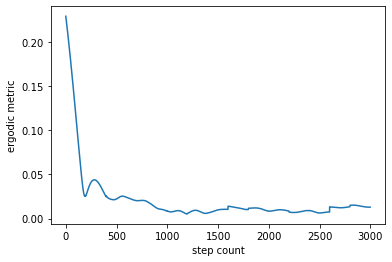

In [11]:
plt.plot(erg_metric[:-1])
plt.xlabel("step count")
plt.ylabel("ergodic metric")
# If the loss is diverging away from zero for very large d or large K0:
# increase rmax_ for ttWt.round() (it will slow down the control loop though)

In [12]:
mean_traj = np.sum(traj,axis=0)/traj.shape[0]
mean_act = np.sum(mu*c.reshape(-1,1),axis=0)
error = np.linalg.norm(mean_traj-mean_act)
print("error in expectation (if GMM was used): ",error)

error in expectation (if GMM was used):  0.008321922413204702


  0%|          | 0/2 [00:00<?, ?it/s]


For a good accuracy of contour plot, increase n_sections in the current cell of the notebook


100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


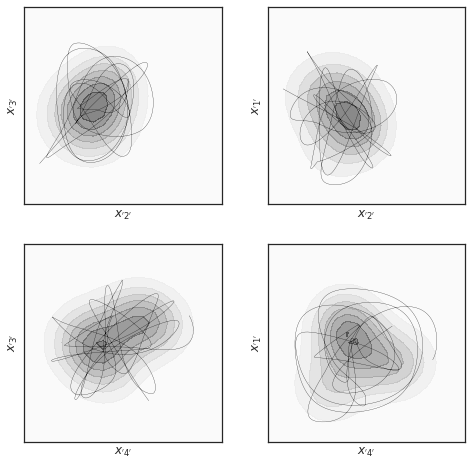

In [15]:
# Plot 4 randomly chosen coordinates

plt.style.use('seaborn-white')
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(8)

# Randomly choose axis to plot
a = np.arange(d).tolist()
random.shuffle(a)
ix_ = a[:2]
iy_ = a[2:4]


m = -1 # number of samples from the trajectory to plot

# Discretize the statespace for plotting
dh0 = 0.05
n_sections = 20 # number of 2D slices for contour plot (increase it for better accuracy of contour plot )
print("\nFor a good accuracy of contour plot, increase n_sections or decrease dh0 in the current cell of the notebook")
xa = np.arange(0,L+dh0,dh0)  # discretize each dimensions
n = [len(xa) for i in range(d)] # number of dscrete states along each dimension
xx,yy = np.meshgrid(xa,xa)
ctx = -1
if d==2:
    ix_tqdm= [0]
    iy_ = [1]
else:
    ix_tqdm = tqdm(ix_)
for ix in ix_tqdm :
    ctx+=1
    cty=-1
    for iy in iy_:
        cty+=1
        P_ = np.empty([n[ix],n[iy]])
        for i,x_ in enumerate(xa):
            for j,y_ in enumerate(xa): 
                P_[i,j]=0
                for a_ in np.linspace(0,1,n_sections): 
                    x = [a_*L]*d
                    x[ix] = x_
                    x[iy] = y_
                    P_[i,j] = p(x)+P_[i,j]
        
        ax[ctx,cty].contourf(xa,xa,P_.T, alpha=0.5)
        ax[ctx,cty].plot(traj[0:m,ix],traj[0:m,iy],'-k', linewidth=0.25)
        ax[ctx,cty].set_xlabel("$x_{}$".format({str(ix+1)}),fontsize=12)
        ax[ctx,cty].set_ylabel("$x_{}$".format({str(iy+1)}),fontsize=12)
        ax[ctx,cty].set_xlim([0,L])
        ax[ctx,cty].set_ylim([0,L])
        ax[ctx,cty].set_aspect('equal')
        ax[ctx,cty].set_xticks([])
        ax[ctx,cty].set_yticks([])



# Comparision

The following cells is not part of the algorithm and just here to show the difficulty in computing 
the Fourier coefficients in the standard approach. Run it if you are curious. Caution: may hang the notebook if d is larger than 4! Also, it needs patience as it may take a long time to compute one Fourier coefficient.


In [14]:

# # In this cell, we compute one randomly chosen Fourier coefficient (there are K0^d in total)
# d_ = 1*d # For a d=d_

# K_tmp = [np.random.randint(0,K) for i in range(d_)] # randlomly select a Fourier basis function
# def integrand(*args):
#     phi_K = np.prod([np.cos(np.pi*args[i]*K_tmp[i]/L) for i in range(d)])
#     c_ = p(np.array(args))
#     return c_*phi_K
# t0=time.time()
# f_coef,_= integrate.nquad(integrand, [[0,L]]*d) # compute the Fourier coefficient (alternatively use Monte Carlo Integration)
# t1= time.time()
# print("Time taken to compute one Fourier Coefficint in a naive way (1): ", (t1-t0)/60," minutes")


# # # Method 2: Integration usng MCMC
# # import mcint
# # def integrand(x):
# #     phi_K = np.prod([np.cos(np.pi*x[i]*K_tmp[i]/L) for i in range(d_)])
# #     c_ = p(np.array(x))
# #     return c_*phi_K

# # def sampler():
# #     while True:
# #         x_sample     = np.random.uniform(0.,1.,d_)
# #         yield x_sample



# # np.random.seed(1)
# # t0 = time.time()
# # result, error = mcint.integrate(integrand, sampler(), measure=1.0, n=10**5)
# # t1=time.time()
# # print("expected error in MC integration (increase n if the error is large): ",error)
# # print("Time taken to compute one Fourier Coefficient in a naive way (2): ", (t1-t0)/60," minutes")



